In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import ast
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import  r2_score, mean_absolute_error
import warnings
import statsmodels.api as sm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
warnings.filterwarnings("ignore", category=Warning)  # Suppress all warnings

In [4]:
df = pd.read_csv('data/DeBERTa-v3/complete_De-BERTa_plots.csv')
df.shape

(9500, 7)

In [3]:
metadata_df = pd.read_csv('movies_metadata_ratings.csv')
genres_df = metadata_df[['movie_genres','wiki_movie_id']].copy()

In [4]:
def transform_genres_string(genres_str):
    try:
        genres_dict = json.loads(genres_str.replace("'", "\""))  # Replace single quotes with double quotes
        return genres_dict
    except json.JSONDecodeError:
        return {}
genres_df['movie_genres'] = genres_df['movie_genres'].apply(transform_genres_string)
genres_df.shape

(20216, 2)

In [5]:

#for filtering out genres with less than threshold movies
def prep_data(threshold, genres_df, show_plot=False):    
    genre_counts = genres_df['movie_genres'].apply(lambda x: list(x.values())).explode().value_counts()
    genre_counts = genre_counts[genre_counts > threshold]
    genre_counts = genre_counts.sort_values(ascending=True)
    top_genres_value_list = genre_counts.index.tolist()
    if show_plot:
        genre_counts.plot(kind='barh')
        plt.xlabel('Counts')
        plt.ylabel('Genres')
        plt.title('Genre Counts')
        plt.show()
    return top_genres_value_list, genres_df

#doing linear regression on genres
def linear_regression(X_column_names,y_column_names, df):
    df_train = df.sample(frac=0.85, random_state=1)
    df_test = df.drop(df_train.index)

    X = sm.add_constant(df_train[X_column_names])
    model = sm.OLS(df_train[y_column_names], X).fit()

    X_test = sm.add_constant(df_test[X_column_names])
    preds = model.predict(X_test)

    mae = mean_absolute_error(df_test[y_column_names], preds)
    return model, mae

#getting genrres in one hot encoding
def get_genre_dummies(metadata_df, threshold=100):
    genres_df = metadata_df[['movie_genres']].copy()
    genres_df['movie_genres'] = genres_df['movie_genres'].apply(transform_genres_string)
    
    top_genres_value_list, genres_df = prep_data(threshold, genres_df)

    genres_df = genres_df.drop(genres_df[genres_df['movie_genres'].apply(lambda x: not any(genre in x.values() for genre in top_genres_value_list))].index)
    dummy_variables = pd.get_dummies(genres_df['movie_genres'].apply(lambda x: list(x.values())).explode())
    dummy_variables = dummy_variables[top_genres_value_list]  # Filter dummy variables for top genres
    dummy_variables = dummy_variables.groupby(dummy_variables.index).sum()  # Group by movie ID
    dummy_variables = dummy_variables.astype(int)
    return dummy_variables
#used for quick testing, given full dataframe with needed inxes filterred out and genre information present, 
# get linear regression model and mae

def full_genre_process(metadata_df, threshold=100,  list_of_other_cols=['averageRating']):
    dummy_variables = get_genre_dummies(metadata_df, threshold)
    genres_df = dummy_variables.merge(metadata_df[list_of_other_cols], left_index=True, right_index= True, how='left').copy()

    X_column_names = [col for col in genres_df.columns if col != 'averageRating' ]
    y_column_names = ['averageRating']
    
    return linear_regression(X_column_names,y_column_names, genres_df)



In [6]:
model, mae = full_genre_process(metadata_df, threshold=100,  list_of_other_cols=['averageRating'])
print("Mean absolute error of linear regression on genres is ",mae)


Mean absolute error of linear regression on genres is  0.725609751540359


# Predicting Movie rating soleley on genre information

Running linear regression with a 0.8/0.2 or 0.85/0.15 train/test split, we get a mean absolute error of 0.72 for a threshold of 750 (meaning genres with less than 750 representatives aaren't represented), we coul use a stricter or more loosse threshold, the result doesn't change all that much. It would be interresting to if the time when the film went out plays a role in the films' sucess.

In [7]:
def show_model(model,top_to_show=5):
    SHOW_TOP_COEF = top_to_show
    model_df = pd.DataFrame(model.summary().tables[1])

    model_df.columns = model_df.iloc[0]
    model_df.columns = ['Genre', 'Coefficient', 'Standard Error', 't-value', 'p-value', '95% CI Lower', '95% CI Upper']
    model_df = model_df[1:].copy()
    for col in model_df.columns:
        model_df[col] = model_df[col].apply(lambda x: x.data)
    for col in model_df.columns[1:]:
        model_df[col] = model_df[col].astype(float)
    coef = model_df['Coefficient'].iloc[0]
    model_df = model_df[1:].copy()
    filtered_model_df = model_df[model_df['p-value'] <= 0.05]

    top = model_df.nlargest(SHOW_TOP_COEF, 'Coefficient')
    bottom = model_df.nsmallest(SHOW_TOP_COEF, 'Coefficient')
    filtered_model_df = pd.concat([top, bottom])

    # Create a Plotly figure with custom error bars
    fig = go.Figure()

    for index, row in filtered_model_df.iterrows():
        genre = row['Genre']
        coef = row['Coefficient'] 
        std_error = row['Standard Error']
        ci_lower = row['95% CI Lower']
        ci_upper = row['95% CI Upper']
        
        # Add a bar trace with custom error bars
        fig.add_trace(go.Bar(
            x=[coef],
            y=[genre],
            orientation='h',
            error_x=dict(
                type='data',
                symmetric=False,
                array=[ci_upper],
                arrayminus=[ci_lower]
            ),
            name=genre
        ))

    # Customize the layout
    fig.update_layout(
        yaxis_title='Label',
        xaxis_title='Coefficient Value',
        title='Coefficients with Confidence Intervals (95%)',
        barmode='group'  # Use 'group' to display multiple bars per genre
)

# Show the plot
    fig.show()

In [8]:
show_model(model)

How certain can we be of our guess, when predicting on genres? Data shows, that it doesn't purely depend on the genre in question (cf model results and p-values of different coefficients, represented on this graph) but also on the year in question. Running linear regression on data grouped by yars, we can see a steady risse in error, indicating more unceartainty present in recent years. A logical observation would be to account for more recent films in our data in addition to older films haven gone through the proof of time.

or someething like:  as we can see, the uncertainty grows with the years. First of all, we have to remember that our data has more releses closer to the present. Logically, the films that "stood the test of time" and found their way into the dataset are more likely to be of better quality, since they have not been forgotten, while the modern creations find their way into lists without any paticular trrouble.

# Looking at errors when training and testing on the same year

In [9]:
years = list(range(1930, 2020, 5))
errors = []
for year in years:
    df = metadata_df.copy()
    filt_metadata_df = df[metadata_df['movie_release_year'] < year]
    filt_metadata_df = filt_metadata_df[filt_metadata_df['movie_release_year'] >= year-5]
    errors.append(full_genre_process(filt_metadata_df, 100, list_of_other_cols=['averageRating'])[1])

fig = go.Figure(data=go.Scatter(x=years, y=errors, mode='lines+markers'))
fig.update_layout(title='Linear Regression Mean Absolute Error for a given 5 year period',
                  xaxis_title='Years',
                  yaxis_title='Mean Absolute Error')
fig.show()


In [10]:

# Plot 1: Average Rating per Year (Line Plot)
df = metadata_df[metadata_df['movie_release_year']>1920].copy().groupby('movie_release_year')['averageRating'].mean().reset_index()
# Create a line trace for "Average Rating per Year"
line_trace = go.Scatter(
    x=df['movie_release_year'],
    y=df['averageRating'],
    mode='lines',
    name='Average Rating',
    line=dict(color='blue'),  # Customize line color
)

# Create a layout
layout = go.Layout(
    title='Average Rating per Year',
    xaxis=dict(title='Years'),
    yaxis=dict(title='Average Rating'),
)
fig1 = go.Figure(data=[line_trace], layout=layout)
fig1.update_xaxes(title_text='Years')
fig1.update_yaxes(title_text='Average Rating')

# Plot 2: Distribution of Top 1000 Movies by Year (Histogram)
df_top_1000 = metadata_df.sort_values(by='averageRating', ascending=False).head(1000)
fig2 = px.histogram(df_top_1000, x='movie_release_year', nbins=10, title='Distribution of Top 1000 Movies by Year')
fig2.update_xaxes(title_text='Years')
fig2.update_yaxes(title_text='Counts')

# Create a subplot with two plots vertically
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=2, col=1)

# Update layout and titles
fig.update_layout(height=600, title_text="Average Ratings per year vs Top 1000 Movie Distribution Over Years")

# Show the plot
fig.show()



# Where them good fims at?
A as we can see, the avarrage ratting of films seems to go down throughouut years, yet if we analise the top 1000 movies, we see that they are more likeley to be found in the recent years. Considering that the evaluation of movie genres wasn't quite sufficient, why not try gain more information on their "vibe" by analising the plots. Such analysis can be conducted with the aid of NLP tools, it is however important to reflect on what sort of information we want to use. 

Having observed the different prrertrained models and their caapabilaties (as much as the capabilaties of our hardware), it seemed that an interesting aproach would be utilizing the zero-shot-classification capabilaty of DeBERTa-v3-base-mnli-fever-anli, a pretrained and fine-tuned model we found on hugging face. Given a text and a list of labels as input, the model assigns probabilaties to each of the labels (together summing to 1). Thus, an interesting aprroach would be to create multiple lists with emelements from similar groups and running thee model on all the texts and lists, get orer informattion about the time period described in the plot, a particular way the plot was constructed, what sort of problem is the story constructed around etc. 

Since this is a computation heavy process, it was decided to only run in on parrt of our dataset, nameley films coming out after 1980 and having more than 1000 votes. This still gave us 9900 samples to worrk with.


In [58]:
def filter_dictionnary(dict, threshold):
    return {key: value for key, value in dict.items() if value > threshold}

def create_labels_df(threshold = 0.5, path_to_file = 'data/DeBERTa-v3/complete_De-BERTa_plots.csv'):
    concat_labels_df = pd.read_csv(path_to_file)
    concat_labels_df = concat_labels_df.drop_duplicates(subset=['wiki_movie_id'])
    concat_labels_df = concat_labels_df.set_index('wiki_movie_id')
    #concat_labels_df = concat_labels_df[~concat_labels_df.index.duplicated(keep='first')]
    #checking that no duplicate indexes are present
    assert len(concat_labels_df.index) == concat_labels_df.index.nunique()

    concat_labels_df['labels'] = concat_labels_df['labels'].apply(ast.literal_eval) 
    concat_labels_df = concat_labels_df.sort_values('averageRating', ascending=False)
    rating_labels = concat_labels_df[['averageRating','movie_name','labels']].copy()

    rating_labels['labels'] = rating_labels['labels'].apply(lambda x: filter_dictionnary(x, threshold))
    #rating_labels = rating_labels[~rating_labels.index.duplicated(keep='first')]
    assert len(rating_labels.index) == rating_labels.index.nunique()


    return rating_labels


In [34]:
#get the keys aka unique labels
def get_unique_labels(rating_labels):
    keys = set()
    for label_dict in rating_labels['labels']:
        keys.update(label_dict.keys())
    return keys
print("Number of unique labels is ", len(get_unique_labels(create_labels_df(0.5))))

Number of unique labels is  228


In [60]:
def filter_label_count(label_count, min_nb_to_keep, max_nb_to_keep, show_counts, top_counts_to_show): 
    df = label_count.copy()
    df = df[df > min_nb_to_keep]
    df = df[df < max_nb_to_keep]
    df = df.sort_values(ascending=False)
    top_df  = df.head(top_counts_to_show)
    if show_counts:
        fig = go.Figure(data=[go.Bar(x=top_df.values, y=top_df.index, orientation='h')])
        fig.update_layout(
            title='Label Counts',
            xaxis=dict(title='Count'),
            yaxis=dict(title='Label'),
        )
        fig.show()
    return df

def get_label_dumies(rating_labels,labels_to_keep):    
    #creating dummy variables for labels
    dummy_variables = pd.get_dummies(rating_labels['labels'].apply(lambda x: list(x.keys())).explode())
    dummy_variables = dummy_variables[labels_to_keep]  # Filter dummy variables for top genres
    dummy_variables = dummy_variables.groupby(dummy_variables.index).sum() # Group by movie ID
    return dummy_variables.astype(int)    

def filter_labels_df(min_nb_to_keep, 
                     max_nb_to_keep, 
                     certainty , 
                     show_counts, 
                     top_counts_to_show,
                     show_mean_ratings, 
                     top_mean_ratings_to_show):    
    rating_labels = create_labels_df(certainty)
    label_count = rating_labels['labels'].apply(lambda x: list(x.keys())).explode().value_counts()
    label_count = filter_label_count(label_count ,min_nb_to_keep, max_nb_to_keep, show_counts, top_counts_to_show)
    print("Number of labels after filtering is ", len(label_count))
    label_columns = label_count.index.tolist()
    #only leaving labels that are in the filtered zone 
    rating_labels = rating_labels.drop(rating_labels[rating_labels['labels'].apply(lambda x: not any(label in x.keys() for label in label_columns))].index)
    if show_mean_ratings:
        mean_ratings = rating_labels.explode('labels').groupby('labels')['averageRating'].mean()
        mean_ratings = mean_ratings.sort_values(ascending=False).head(top_mean_ratings_to_show)
        fig = go.Figure(data=[go.Bar(x=mean_ratings.values, y=mean_ratings.index, orientation='h')])
        fig.update_layout(
            title='Label Means',
            xaxis=dict(title='Mean'),
            yaxis=dict(title='Label'),
        )
        # Show the plot
        fig.show()
    return rating_labels, label_columns

def get_dummy_labels_with_score(min_nb_to_keep, 
                                max_nb_to_keep, 
                                certainty = 0.5, 
                                show_counts = False, 
                                top_counts_to_show = 5,
                                show_mean_ratings = False,
                                top_mean_ratings_to_show = 5):
    rating_labels, label_columns = filter_labels_df(min_nb_to_keep, 
                                                    max_nb_to_keep, 
                                                    certainty, 
                                                    show_counts,
                                                    top_counts_to_show, 
                                                    show_mean_ratings, 
                                                    top_mean_ratings_to_show)
    dummy_labels = get_label_dumies(rating_labels, label_columns)
    rating_labels = dummy_labels.merge(rating_labels[['averageRating']], left_index=True, right_index= True, how='left').copy()
    return rating_labels


In [ ]:
dummy_labels = get_dummy_labels_with_score(200, 1000, 0.6, show_counts=False, top_counts_to_show=10, show_mean_ratings=False, top_mean_ratings_to_show=10)

fianlly, we perform a linear regression on the data

In [44]:
model, mal = linear_regression(dummy_labels,['averageRating'], rating_labels)
print("mean abssolute losss when doing linear regreession is: ", mal )


mean abssolute losss when doing linear regreession is:  0.7396168887919836


we then check how will the same samples would compare if we try to predict soleley on their genre data

In [ ]:
metadata = pd.read_csv('movies_metadata_ratings.csv')
metadata = metadata.drop_duplicates(subset='wiki_movie_id')
metadata = metadata.set_index('wiki_movie_id')

In [45]:
df = metadata.copy()
df = df.loc[rating_labels.index]
genre_model , genre_mal = full_genre_process(df, 100)
print("mean abssolute losss when doing linear regreession on genre column is: ", genre_mal )

mean abssolute losss when doing linear regreession on genre column is:  0.6640714699223265


In [46]:
show_model(model)

As we can see, the confidence intervals are larger than in the case of genres and the most influentual labels are those that correlate the modst with a specific genre, however this is more information we can work with and it seems to be menaingful in one way or another. Now, it would be interesting to combine thhe knowledge we have on genres and labels together in order to get a more specialised model.

In [47]:
metadata = pd.read_csv('movies_metadata_ratings.csv')
metadata = metadata.drop_duplicates(subset='wiki_movie_id')
metadata = metadata.set_index('wiki_movie_id')

df = metadata.copy()
df = df.loc[rating_labels.index]
df = get_genre_dummies(df, 1000)
df = df.merge(rating_labels, left_index=True, right_index=True, how='left')
combined_model, combined_mae = linear_regression(df.columns[:-1],['averageRating'], df)
print("mean abssolute losss when doing linear regreession on genre combined with labels is: ", combined_mae )

mean abssolute losss when doing linear regreession on genre combined with labels is:  0.6239053872665239


In [48]:
df 

,Indie,World cinema,Action,Romance Film,Thriller,Comedy_x,Drama,Voyage and Return,Tense,Suburbia,...,Social Injustice,Betrayal,World War II,Space Exploration,Loss and Grief,Rebirth,Mentorship,Small Town,Whimsical,averageRating
wiki_movie_id,,,,,,,,,,,,,,,,,,,,,
417744,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.5


Lower, we see two graphics, showing that the loss goes down together with the additionnal labels
- imma add more eplanations if we find this interesting

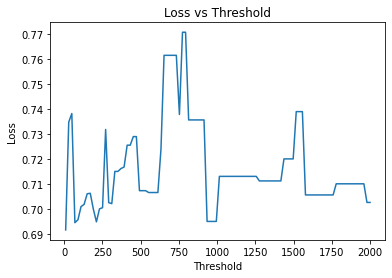

In [21]:
df = pd.read_csv('movies_metadata_ratings.csv')
df = df.drop_duplicates(subset='wiki_movie_id')
df = df.set_index('wiki_movie_id')

df_filtered = df[df['movie_release_year'] > 1980]
df_filtered = df_filtered[df_filtered['numVotes'] > 1000]

threshes = np.linspace(10, 2000, 100)
losses = []
for thresh in threshes:
    model, loss = full_genre_process(df_filtered, thresh)
    losses.append(loss)

plt.plot(threshes, losses)    
plt.xlabel('Threshold')
plt.ylabel('Loss')
plt.title('Loss vs Threshold')
plt.show()


# we mananage to gain around 0.1 in mean absolute error

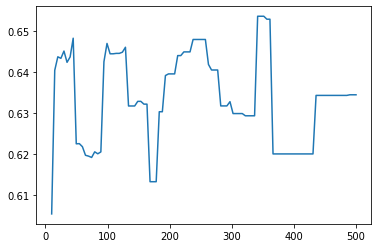

In [22]:
df = pd.read_csv('movies_metadata_ratings.csv')
df = df.drop_duplicates(subset='wiki_movie_id')
df = df.set_index('wiki_movie_id')
df = df.loc[rating_labels.index].copy()
losses = []

threshes = np.linspace(10, 500, 100)
for thresh in threshes:
    df_filtered = get_genre_dummies(df, thresh)
    df_filtered = df_filtered.merge(rating_labels, left_index=True, right_index=True, how='left')
    combined_model, combined_mae = linear_regression(df_filtered.columns[:-1],['averageRating'], df_filtered)
    losses.append(combined_mae)

plt.plot(threshes, losses)


# Experemental part to leave out

In [23]:
#furhter filtering out labels and all for better results
def get_label_dumies(min_occurrences,max_occurences, threshold=0.5):
    label_count = get_labels_count(threshold)
    label_count = label_count[label_count > min_occurrences]
    label_count = label_count[label_count < max_occurences]
    rating_labels = get_labels_rating_df(threshold)
    
    label_columns = label_count.index.tolist()
    #only leaving labels that are in the filtered zone 
    rating_labels = rating_labels.drop(rating_labels[rating_labels['labels'].apply(lambda x: not any(label in x.keys() for label in label_columns))].index)

    #creating dummy variables for labels
    dummy_variables = pd.get_dummies(rating_labels['labels'].apply(lambda x: list(x.keys())).explode())
    dummy_variables = dummy_variables[label_columns]  # Filter dummy variables for top genres
    dummy_variables = dummy_variables.groupby(dummy_variables.index).sum()  # Group by movie ID
    dummy_variables = dummy_variables.astype(int)

    rating_labels = dummy_variables.merge(rating_labels[['averageRating']], left_index=True, right_index= True, how='left').copy()
    return rating_labels

In [24]:
#this didn't really help either

def random_forest_mae(X_train, X_test, y_train, y_test, n_estimators=100):
    # Create the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters like n_estimators
    # Train the model
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    mae = (mean_absolute_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return mae, r2

def gradient_boosting_mae(X,y):
    # Create the Gradient Boosting model
    gb_model = GradientBoostingRegressor(random_state=42)
    clf_1_results = cross_validate(gb_model, X, y, cv=3, scoring=('neg_mean_absolute_error'))
    return np.abs(clf_1_results['test_score'].mean())